# Autores: 
**Gabriel Roberto (221020870) e Jean Soares (241033810)**

In [1]:
from d2l import tensorflow as d2l
import tensorflow as tf
import requests
import tarfile
import re
import collections
import pandas as pd
from random import choices
from nltk.translate import IBMModel1
from nltk.translate.bleu_score import sentence_bleu


2025-02-16 16:25:01.835577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def baixar_arquivo(url, endereco):
    resposta = requests.get(url)
    if resposta.status_code == requests.codes.OK:
        with open(endereco, 'wb') as novo_arquivo:
                novo_arquivo.write(resposta.content)
        print("Download finalizado. Arquivo salvo em: {}".format(endereco))
    else:
        resposta.raise_for_status()

In [3]:
URL_arquivo = 'https://www.statmt.org/europarl/v7/pt-en.tgz'

baixar_arquivo(URL_arquivo, './raw_dataset.tgz')

Download finalizado. Arquivo salvo em: ./raw_dataset.tgz


In [4]:
# Caminho para o arquivo .tgz
caminho_arquivo = './raw_dataset.tgz'

# Abrir o arquivo .tgz
with tarfile.open(caminho_arquivo, 'r:gz') as arquivo_tgz:
    # Extrair todos os arquivos do .tgz
    arquivo_tgz.extractall(path='./')

    # Listar os arquivos extraídos
    for membro in arquivo_tgz.getmembers():
        print(membro.name)

europarl-v7.pt-en.en
europarl-v7.pt-en.pt


# Leitura do Dataset

In [5]:
class ParallelCorpus(d2l.DataModule):
    """The Parallel Corpus Portuguese-English dataset."""
    def _download(self, fname):
        with open(fname, encoding="utf-8") as f:
            return f.read()

In [6]:
data = ParallelCorpus()
raw_text_en = data._download('./europarl-v7.pt-en.en')
raw_text_en[:60]

'Resumption of the session\nI declare resumed the session of t'

In [7]:
raw_text_pt = data._download('./europarl-v7.pt-en.pt')
raw_text_pt[:60]

'Reinício da sessão\nDeclaro reaberta a sessão do Parlamento E'

In [8]:
@d2l.add_to_class(ParallelCorpus)
def _preprocess(self, text):
    return re.sub(r'[^\w\s]', '', text).lower()

In [9]:
text_en = data._preprocess(raw_text_en).split('\n')

del raw_text_en
text_en[:10]

['resumption of the session',
 'i declare resumed the session of the european parliament adjourned on friday 17 december 1999 and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period',
 'although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful',
 'you have requested a debate on this subject in the course of the next few days during this partsession',
 'in the meantime i should like to observe a minute s silence as a number of members have requested on behalf of all the victims concerned particularly those of the terrible storms in the various countries of the european union',
 'please rise then for this minute s silence',
 'the house rose and observed a minute s silence',
 'madam president on a point of order',
 'you will be aware from the press and television that there have been a number of bomb explosi

In [10]:
text_pt = data._preprocess(raw_text_pt).split('\n')

del raw_text_pt
text_pt[:10]

['reinício da sessão',
 'declaro reaberta a sessão do parlamento europeu que tinha sido interrompida na sextafeira 17 de dezembro último e renovo todos os meus votos esperando que tenham tido boas férias',
 'como puderam constatar o grande bug do ano 2000 não aconteceu em contrapartida os cidadãos de alguns dos nossos países foram vítimas de catástrofes naturais verdadeiramente terríveis',
 'os senhores manifestaram o desejo de se proceder a um debate sobre o assunto nos próximos dias durante este período de sessões',
 'entretanto gostaria  como também me foi pedido por um certo número de colegas  que observássemos um minuto de silêncio por todas as vítimas nomeadamente das tempestades nos diferentes países da união europeia que foram afectados',
 'convidoos a levantaremse para um minuto de silêncio',
 'o parlamento de pé guarda um minuto de silêncio',
 'senhora presidente intervenho para um ponto de ordem',
 'certamente que já tomou conhecimento pelas notícias transmitidas na imprensa

# Tokenização

Visando facilitar a comparação entre sentenças entre os idiomas, foi optado colocar cada sentença lado a lado, separadas por um tab. Dessa forma, a primeira sentença de cada idioma estará na primeira linha, a segunda sentença na segunda linha e assim por diante.

In [11]:
text = '\n'.join(['\t'.join([text_pt[i],text_en[i]]) for i in range(max(len(text_pt), len(text_en)))])

In [12]:
@d2l.add_to_class(ParallelCorpus)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[:3], tgt[:3]

([['reinício', 'da', 'sessão', '<eos>'],
  ['declaro',
   'reaberta',
   'a',
   'sessão',
   'do',
   'parlamento',
   'europeu',
   'que',
   'tinha',
   'sido',
   'interrompida',
   'na',
   'sextafeira',
   '17',
   'de',
   'dezembro',
   'último',
   'e',
   'renovo',
   'todos',
   'os',
   'meus',
   'votos',
   'esperando',
   'que',
   'tenham',
   'tido',
   'boas',
   'férias',
   '<eos>'],
  ['como',
   'puderam',
   'constatar',
   'o',
   'grande',
   'bug',
   'do',
   'ano',
   '2000',
   'não',
   'aconteceu',
   'em',
   'contrapartida',
   'os',
   'cidadãos',
   'de',
   'alguns',
   'dos',
   'nossos',
   'países',
   'foram',
   'vítimas',
   'de',
   'catástrofes',
   'naturais',
   'verdadeiramente',
   'terríveis',
   '<eos>']],
 [['resumption', 'of', 'the', 'session', '<eos>'],
  ['i',
   'declare',
   'resumed',
   'the',
   'session',
   'of',
   'the',
   'european',
   'parliament',
   'adjourned',
   'on',
   'friday',
   '17',
   'december',
   '1999',

In [13]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

A distribuição dos token nas sequências desse dataset inglês-português é mostra que a maioria das sentenças tem 100 tokens ou menos. A distribuição é bem similar entre os dois idiomas.

10000 primeiras centenças do dataset:

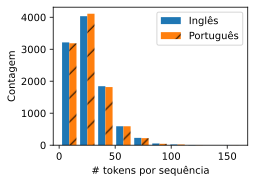

In [14]:
show_list_len_pair_hist(['Inglês', 'Português'], '# tokens por sequência',
                        'Contagem', src[:10000], tgt[:10000])

50000 primeiras centenças do dataset:

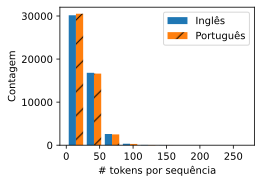

In [15]:
show_list_len_pair_hist(['Inglês', 'Português'], '# tokens por sequência',
                        'Contagem', src[:50000], tgt[:50000])

## Obtendo sequências com dado comprimento fixo

In [16]:
@d2l.add_to_class(ParallelCorpus)  #@save
def __init__(self, batch_size, src_file, tgt_file, num_steps=9, num_train=512, num_val=128):
    super(ParallelCorpus, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download(src_file), self._download(tgt_file))

@d2l.add_to_class(ParallelCorpus)  #@save
def _build_arrays(self, raw_src_text, raw_tgt_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = tf.constant([vocab[s] for s in sentences])
        valid_len = tf.reduce_sum(
            tf.cast(array != vocab['<pad>'], tf.int32), 1)
        return array, vocab, valid_len
    text_src= self._preprocess(raw_src_text).split('\n')
    text_tgt = self._preprocess(raw_tgt_text).split('\n')
    joined_text = '\n'.join(['\t'.join([text_src[i],text_tgt[i]]) for i in range(max(len(text_src), len(text_tgt)))])
    src, tgt = self._tokenize(joined_text,
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)


## Fazendo a leitura do dataset

In [17]:
@d2l.add_to_class(ParallelCorpus)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

In [18]:
data = ParallelCorpus(batch_size=10, src_file="./europarl-v7.pt-en.en" ,tgt_file="./europarl-v7.pt-en.pt")
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', tf.cast(src, tf.int32))
print('decoder input:', tf.cast(tgt, tf.int32))
print('source len excluding pad:', tf.cast(src_valid_len, tf.int32))
print('label:', tf.cast(label, tf.int32))

2025-02-16 16:27:42.225644: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-02-16 16:27:42.820932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [512,9]
	 [[{{node Placeholder/_3}}]]
2025-02-16 16:27:42.821869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [512,9]
	 [[{{node Placeholder/_1}}]]


source: tf.Tensor(
[[ 42 150 467 206 288 199 494 228 450]
 [257 471 474 206 139   1   2   2   2]
 [143 432  30 422  59 432 344 213   3]
 [ 26 206 284 450   3 285 270 450   3]
 [285  31 156 432 146   3 184 199  55]
 [432   3 329 484   3 150   3   3   3]
 [432   3 360 276   3 178 328  77  53]
 [232 317 199 494 147 228 450 302 287]
 [206 278 274 432   3   9 450 184 273]
 [199 494  43 431 439   3 397 444 213]], shape=(10, 9), dtype=int32)
decoder input: tf.Tensor(
[[  1 302 169 302 422 464   4  33 339]
 [  1 317 281   4 172   5 214   2   3]
 [  1 220   5  23 409 350 444 558  35]
 [  1 337  97   4 337  97   4  47   4]
 [  1 101 422  47  24 375 316 410   4]
 [  1   5 448 422   4   4   4 184 246]
 [  1 317 446   4 490 331 456 151 406]
 [  1 475 392  32 121 270 231 121 431]
 [  1 313 151   4   7 323   4   5   4]
 [  1 458 422   4 184 123 376  47  76]], shape=(10, 9), dtype=int32)
source len excluding pad: tf.Tensor([9 6 9 9 9 9 9 9 9 9], shape=(10,), dtype=int32)
label: tf.Tensor(
[[302 169 30

In [19]:
@d2l.add_to_class(ParallelCorpus)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_src_text = '\n'.join(src_sentences)
    raw_tgt_text = '\n'.join(tgt_sentences)
    arrays, _, _ = self._build_arrays(
        raw_src_text, raw_tgt_text, self.src_vocab, self.tgt_vocab)
    return arrays

src, tgt, _,  _ = data.build(['mr president ladies and gentlemen'], ['senhor presidente senhoras e senhores'])
print('source:', data.src_vocab.to_tokens(tf.cast(src[0], tf.int32)))
print('target:', data.tgt_vocab.to_tokens(tf.cast(tgt[0], tf.int32)))

source: ['mr', 'president', 'ladies', 'and', 'gentlemen', '<eos>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'senhor', 'presidente', 'senhoras', 'e', 'senhores', '<eos>', '<pad>', '<pad>']


# Treinando o Modelo IBMModel1

Para o treinamento do modelo IBMModel1, foram utilizadas somente as primeiras 10000 sentenças do dataset. O treinamento foi feito com 5 iterações.

In [68]:
from nltk import AlignedSent

bitext = []
for i in range(10000):
    bitext.append(AlignedSent(text_en[i].split(), text_pt[i].split()))

print(bitext[0])
print(bitext[1])
print(bitext[2])


<AlignedSent: 'resumption of the se...' -> 'reinício da sessão...'>
<AlignedSent: 'i declare resumed th...' -> 'declaro reaberta a s...'>
<AlignedSent: 'although as you will...' -> 'como puderam constat...'>


In [69]:
ibm_model = IBMModel1(bitext, 5)  # 5 iterations for training

In [79]:
print(round(ibm_model.translation_table['good']['bom'], 3))
print(round(ibm_model.translation_table['good']['boa'], 3))
print(round(ibm_model.translation_table['president']['presidente'], 3))
print(round(ibm_model.translation_table['parliament']['parlamento'], 3))
print(round(ibm_model.translation_table['european']['europeu'], 3))
print(round(ibm_model.translation_table['european'][None], 3))

0.464
0.73
0.689
0.911
0.844
0.001


É evidente que o modelo, dado que sua tradução é meramente léxica, apresenta uma limitação grande quando não há uma correspondência direta entre as palavras dos dois idiomas. Foi obeservado que o tamanho das sentenças, que se extendiam até 100 tokens em alguns casos, piora a tradução pelo modelo IBMModel1, uma vez que esse não apresenta fluência na tradução de sentenças que apresentam, de um idioma para outro, alguma permutação.
O modelo também apresentou um desempenho abaixo do desejado para palavras que possuem mais de um significado, como "good", que é traduzido para "boa" sem levar em consideração o contexto da sentença.

## Avalição

In [80]:
def translate_sentence(sentence, ibm_model):
    translated_sentence = []
    for word in sentence:
        if word in ibm_model.translation_table:
            # Escolher a palavra de destino com maior probabilidade
            best_translation = max(ibm_model.translation_table[word], key=ibm_model.translation_table[word].get)
            translated_sentence.append(best_translation)
        else:
            translated_sentence.append(word)  # Palavra desconhecida, mantém original
    return translated_sentence

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()

reference = [['o', 'governo', 'é', 'corrupto', 'e', 'ineficiente', 'na', 'gestão', 'dos', 'recursos', 'públicos']]
new_sentence = ['the', 'government', 'is', 'corrupt', 'and', 'inefficient', 'in', 'managing', 'public', 'resources']
candidate = translate_sentence(new_sentence, ibm_model)  # Example machine output
score = sentence_bleu(reference, candidate, smoothing_function=chencherry.method1)

print('Referência: ', reference[0])
print('Tradução do modelo: ', candidate)
print('BLEU: ', score)

Referência:  ['o', 'governo', 'é', 'corrupto', 'e', 'ineficiente', 'na', 'gestão', 'dos', 'recursos', 'públicos']
Tradução do modelo:  ['the', 'governo', 'está', 'corruptos', 'e', 'despedir', 'na', 'convenientemente', 'pública', 'recursos']
BLEU:  0.027007097700389556


In [82]:
score = 0
reference = []
candidate = ''

chencherry = SmoothingFunction()

for i in range(10000):
  reference = [text_pt[i]]
  candidate = translate_sentence(text_en[i], ibm_model)
  score += sentence_bleu(reference, candidate, smoothing_function=chencherry.method1)

mean_BLEU = score / 10000

print('mean_score: ', mean_BLEU)

mean_score:  0.0774073881710767


## Codificador-Decodificador

In [91]:
import tensorflow as tf

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [92]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [93]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return tf.keras.optimizers.Adam(learning_rate=self.lr)

In [89]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = tf.cast(tf.reshape(Y, -1) != self.tgt_pad, tf.float32)
    return tf.reduce_sum(l * mask) / tf.reduce_sum(mask)

In [100]:
data = ParallelCorpus(batch_size=128, src_file="./europarl-v7.pt-en.en" ,tgt_file="./europarl-v7.pt-en.pt")
embed_size, num_hiddens, num_layers, dropout = 256, 256, 4, 0.25
with d2l.try_gpu():
    encoder = Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=20, gradient_clip_val=1)
trainer.fit(model, data)

: 

In [94]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len, training=False)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tf.expand_dims(tgt[:, 0], 1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state, training=False)
        outputs.append(tf.argmax(Y, 2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return tf.concat(outputs[1:], 1), attention_weights

In [95]:
import math

def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
# usar palavras comuns em ParallelCorpus, de cunho judiciario
engs = ['the european parliament .', 'mr . president .', 'reasumption of the session']
ports = ['o parlamento europeu .', 'senhor presidente .' , 'reinício da sessão']
preds, _ = model.predict_step(
    data.build(engs, ports), d2l.try_gpu(), data.num_steps)
for en, pt, p in zip(engs, ports, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), pt, k=2):.3f}')

the court has considered the evidence => ['<unk>', '<unk>', 'de', '<unk>'], bleu,0.000
the court has considered the evidence => ['<unk>', '<unk>', 'de', '<unk>'], bleu,0.000
